# SC1015 Lab 8
## Introduction
Modern enterprises face decision-making challenges of exponential complexity [1]. Three key drivers include: <br>
(1) the big data revolution increasing decision variables significantly <br>
(2) interdependent real-world systems <br>
(3) objectives with competing priorities [2, 3]. <br>

The team aims to explore combinatorial optimization through a simplified version of the Traffic Jam game. In this environment, an AI agent formulates an optimal path to a goal that minimizes the total number of moves. This is done by mapping board states to moves taken and minimizing vehicle movement.
These same principles scale remarkably to global shipping optimization [4], where:
•	Each port call represents a "move" in the Traffic Jam analogy.
•	Fuel costs and emissions act as the "reward function" to optimize.
•	Weather patterns and port schedules create the "constraint network."
With AI-driven optimization algorithms, shipping companies can find the most efficient routing strategies to improve operational costs, reduce emissions, and ensure timely deliveries. This demonstrates how principles learned in simpler environments can be translated to real-world applications.

## Members
Name: Kee Chong Wei |  Matriculation Number: U2320846D <br>
Name: Jiang Zong Zhe | Matriculation Number: U2322460F <br>
Name: Chew Jin Cheng | Matriculation Number: U2321537J <br>

## References
[1] Berutich Lindquist, J. M. (2017). Robust optimization of algorithmic trading systems. <br>
[2] Mukelabai, M., Nešić, D., Maro, S., Berger, T., & Steghöfer, J. P. (2018, September). Tackling combinatorial explosion: a study of industrial needs and practices for analyzing highly configurable systems. In Proceedings of the 33rd acm/ieee international conference on automated software engineering (pp. 155-166). <br>
[3] Surana, A., Kumara*, S., Greaves, M., & Raghavan, U. N. (2005). Supply-chain networks: a complex adaptive systems perspective. International Journal of Production Research, 43(20), 4235-4265. <br>
[4] Walther, L., Rizvanolli, A., Wendebourg, M., & Jahn, C. (2016). Modeling and optimization algorithms in ship weather routing. International journal of e-navigation and maritime economy, 4, 31-45.


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
import networkx as nx
import queue

In [17]:
# begin by visualising problem space

def printProblemState(mazeGrid):
    ''' Display the maze corresponding to a binary grid
        Input : 2D NumPy array with 'W', 'O','T','G','E' as elements
        Output : Simple print of the corresponding maze
    '''
    (height, width) = mazeGrid.shape
    
    print()
    for i in range(height):
        for j in range(width):
            if mazeGrid[i,j] == 'W': # walls
                print("\u2b1b", end = " ")   # use some other character if the unicode does not print properly
            elif mazeGrid[i,j] == ' ': # empty spaces
                print("\u2b1c", end = " ")
            elif mazeGrid[i,j] == 'G': # goal
                print("\u2690", end=" ")
            elif mazeGrid[i,j] == 'O': # obstacles
                print("\u2780", end= " ")
            elif mazeGrid[i,j] == 'T': # target vehicle
                print("\u26f4", end=" ")
        print()


link to unicode symbols: https://symbl.cc/en/unicode-table/#miscellaneous-symbols-and-arrows

In [18]:
maze = [['W','W','W','W'],
        ['T','O','O','G'],
        ['W','O',' ',' '],
        ['W','W','W','W']]

mazeTuple = (('W','W','W','W'),
        ('T','O','O','G'),
        ('W','O',' ',' '),
        ('W','W','W','W'))
# Convert to a NumPy array
maze = np.array(maze)

# Print the maze using helper functions
print("Maze of dimensions", maze.shape)
printProblemState(maze)

Maze of dimensions (4, 4)

⬛ ⬛ ⬛ ⬛ 
⛴ ➀ ➀ ⚐ 
⬛ ➀ ⬜ ⬜ 
⬛ ⬛ ⬛ ⬛ 


In [ ]:
from collections import defaultdict, deque

# Set goal_position once, independent of the grid.
goal_position = (1, 3) 


class Node:
    def __init__(self, grid, move=None, parent=None):
        self.grid = grid          # grid is a tuple of tuples representing the board
        self.move = move          # a tuple: (piece, from_position, to_position)
        self.parent = parent      # pointer to the previous Node (None for the root)

def find_positions(grid, piece):
    positions = []
    for i, row in enumerate(grid):
        for j, cell in enumerate(row):
            if cell == piece:
                positions.append((i, j))
    return positions

def get_target_position(grid):
    positions = find_positions(grid, 'T')
    return positions[0] if positions else None

def manhattan_distance(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def is_goal(grid):
    # Goal is reached when T occupies the same cell as G.
    return get_target_position(grid) == goal_position

def move_piece(grid, pos, direction):
    rows, cols = len(grid), len(grid[0])
    grid_list = [list(row) for row in grid]
    x, y = pos
    dx, dy = direction
    new_x, new_y = x + dx, y + dy

    # Check boundaries.
    if not (0 <= new_x < rows and 0 <= new_y < cols):
        return None

    target_piece = grid_list[x][y]
    destination = grid_list[new_x][new_y]

    if target_piece == 'T':
        # Allow T to move into an empty space or the goal.
        if destination in [' ', 'G']:
            grid_list[new_x][new_y] = 'T'
            # Restore the goal if T moves away from it.
            grid_list[x][y] = 'G' if grid_list[x][y] == 'T' and (x, y) == goal_position else ' '
        else:
            return None
    else:
        # For obstacles, allow only movement into empty space.
        if destination == ' ':
            grid_list[new_x][new_y] = target_piece
            grid_list[x][y] = ' '
        else:
            return None

    return tuple(tuple(row) for row in grid_list)

def expand_node(node):
    children = []
    grid = node.grid
    t_pos = get_target_position(grid)
    g_pos = goal_position
    
    if not t_pos or not g_pos:
        return children

    # Directions: up, down, left, right.
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    current_distance = manhattan_distance(t_pos, g_pos)

    # First try moves for T that reduce the Manhattan distance.
    for d in directions:
        new_grid = move_piece(grid, t_pos, d)
        if new_grid:
            new_t_pos = get_target_position(new_grid)
            new_distance = manhattan_distance(new_t_pos, g_pos)
            if new_distance < current_distance:
                move = ('T', t_pos, (t_pos[0] + d[0], t_pos[1] + d[1]))
                children.append(Node(new_grid, move, node))

    # If T cannot move closer, then expand moves for obstacles.
    if not children:
        obstacles = find_positions(grid, 'O')
        for pos in obstacles:
            for d in directions:
                new_grid = move_piece(grid, pos, d)
                if new_grid:
                    move = ('O', pos, (pos[0] + d[0], pos[1] + d[1]))
                    children.append(Node(new_grid, move, node))
    return children

def search_solution(initial_grid):
    root = Node(initial_grid)
    frontier = deque([root])
    visited = set([str(initial_grid)])
    
    while frontier:
        current_node = frontier.popleft()
        if is_goal(current_node.grid):
            return current_node  # Found goal; return the node to reconstruct the path.
        
        for child in expand_node(current_node):
            state_str = str(child.grid)
            if state_str not in visited:
                visited.add(state_str)
                frontier.append(child)
    return None  # No solution found.

def get_solution_path(node):
    path = []
    while node:
        path.append(node)
        node = node.parent
    path.reverse()
    return path

def get_successors(grid):
    successors = []
    # Convert grid to a mutable structure
    grid_list = [list(row) for row in grid]

    # For each cell in the grid:
    for x in range(len(grid)):
        for y in range(len(grid[0])):
            if grid[x][y] in ('T', 'O'):
                # Try moving up, down, left, right
                for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                    new_grid = move_piece(grid, (x, y), (dx, dy))
                    if new_grid is not None:
                        successors.append(new_grid)
    return successors


def build_state_graph(start_grid):
    graph = defaultdict(list)
    visited = set()
    queue = deque([start_grid])
    visited.add(start_grid)

    while queue:
        current = queue.popleft()
        # Get all possible next states from current
        next_states = get_successors(current)
        for nxt in next_states:
            graph[current].append(nxt)
            if nxt not in visited:
                visited.add(nxt)
                queue.append(nxt)
    return graph

# ------------------------------------------------------------------
# NEW HELPER: Create successor nodes (each with a move attribute)
# This function returns a list of Node objects representing all valid moves
# from the given node.
def get_successor_nodes(node):
    children = []
    grid = node.grid
    # Define the four possible directions: up, down, left, right.
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    for x in range(len(grid)):
        for y in range(len(grid[0])):
            if grid[x][y] in ('T', 'O'):
                for dx, dy in directions:
                    new_grid = move_piece(grid, (x, y), (dx, dy))
                    if new_grid is not None:
                        # Record the move as: (piece moved, from_position, to_position)
                        move = (grid[x][y], (x, y), (x + dx, y + dy))
                        child_node = Node(new_grid, move, node)
                        children.append(child_node)
    return children

# ------------------------------------------------------------------
# BFS using Node objects for a clear solution path.
def bfs_search_nodes(initial_grid, goal_test):
    root = Node(initial_grid)
    queue = deque([root])
    visited = set([str(initial_grid)])
    
    while queue:
        current = queue.popleft()
        if goal_test(current.grid):
            return current  # Return the goal node.
        for child in get_successor_nodes(current):
            state_str = str(child.grid)
            if state_str not in visited:
                visited.add(state_str)
                queue.append(child)
    return None  # No solution found.

# DFS using Node objects.
def dfs_search_nodes(initial_grid, goal_test):
    root = Node(initial_grid)
    stack = [root]
    visited = set([str(initial_grid)])
    
    while stack:
        current = stack.pop()
        if goal_test(current.grid):
            return current  # Return the goal node.
        for child in get_successor_nodes(current):
            state_str = str(child.grid)
            if state_str not in visited:
                visited.add(state_str)
                stack.append(child)
    return None  # No solution found.

def get_solution_path(node):
    path = []
    while node:
        path.append(node)
        node = node.parent
    path.reverse()
    return path


BFS Solution:
Move: None
W W W W
T O O G
W O    
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
T O   G
W O O  
W W W W
-----
Move: ('O', (1, 1), (1, 2))
W W W W
T   O G
W O O  
W W W W
-----
Move: ('T', (1, 0), (1, 1))
W W W W
  T O G
W O O  
W W W W
-----
Move: ('O', (2, 2), (2, 3))
W W W W
  T O G
W O   O
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
  T   G
W O O O
W W W W
-----
Move: ('T', (1, 1), (1, 2))
W W W W
    T G
W O O O
W W W W
-----
Move: ('T', (1, 2), (1, 3))
W W W W
      T
W O O O
W W W W
-----

-------------------------------

DFS Solution:
Move: None
W W W W
T O O G
W O    
W W W W
-----
Move: ('O', (2, 1), (2, 2))
W W W W
T O O G
W   O  
W W W W
-----
Move: ('O', (2, 2), (2, 3))
W W W W
T O O G
W     O
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
T O   G
W   O O
W W W W
-----
Move: ('O', (1, 1), (1, 2))
W W W W
T   O G
W   O O
W W W W
-----
Move: ('T', (1, 0), (1, 1))
W W W W
  T O G
W   O O
W W W W
-----
Move: ('O', (2, 2), (2, 1))
W W W W
  T O G
W O 

In [10]:
solution_node = search_solution(mazeTuple)
if solution_node:
    path = get_solution_path(solution_node)
    for step in path:
        print("Move:", step.move)
        for row in step.grid:
            print(" ".join(row))
        print("-----")
else:
    print("No solution found.")

Move: None
W W W W
T O O G
W O    
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
T O   G
W O O  
W W W W
-----
Move: ('O', (1, 1), (1, 2))
W W W W
T   O G
W O O  
W W W W
-----
Move: ('T', (1, 0), (1, 1))
W W W W
  T O G
W O O  
W W W W
-----
Move: ('O', (2, 2), (2, 3))
W W W W
  T O G
W O   O
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
  T   G
W O O O
W W W W
-----
Move: ('T', (1, 1), (1, 2))
W W W W
    T G
W O O O
W W W W
-----
Move: ('T', (1, 2), (1, 3))
W W W W
      T
W O O O
W W W W
-----


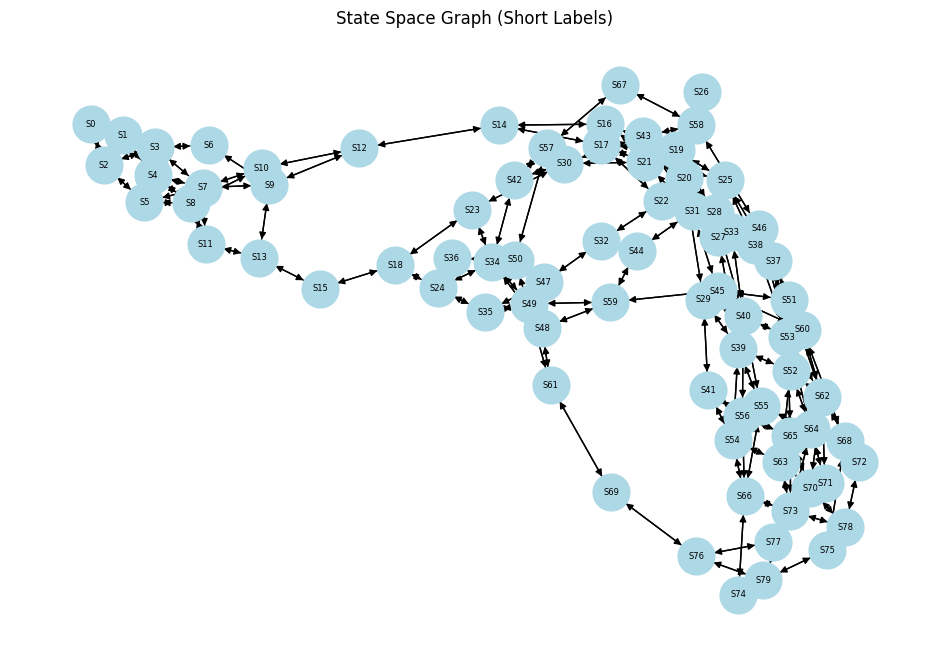

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_state_graph(graph):
    # 1) Create a mapping from state -> short ID
    state_to_id = {}
    id_to_state = {}
    idx = 0

    for state in graph.keys():
        state_to_id[state] = f"S{idx}"
        id_to_state[f"S{idx}"] = state
        idx += 1

    # Also map neighbors
    for state, neighbors in graph.items():
        for nb in neighbors:
            if nb not in state_to_id:
                state_to_id[nb] = f"S{idx}"
                id_to_state[f"S{idx}"] = nb
                idx += 1

    # 2) Build the NetworkX graph
    G = nx.DiGraph()
    for state, neighbors in graph.items():
        state_id = state_to_id[state]
        G.add_node(state_id)
        for nb in neighbors:
            nb_id = state_to_id[nb]
            G.add_node(nb_id)
            G.add_edge(state_id, nb_id)

    # 3) Draw with smaller node size and font
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 8))
    nx.draw_networkx(
        G,
        pos,
        with_labels=True,
        node_size=700,
        node_color="lightblue",
        arrows=True,
        font_size=6
    )
    plt.title("State Space Graph (Short Labels)")
    plt.axis("off")
    plt.show()
graph = build_state_graph(mazeTuple)
visualize_state_graph(graph)

In [12]:
def reconstruct_path(state, parent):
    """
    Reconstructs the path from the initial state to the given state
    using the parent dictionary.
    """
    path = []
    while state is not None:
        path.append(state)
        state = parent[state]
    path.reverse()
    return path

def bfs_search(initial_grid, goal_test):
    """
    Breadth-First Search on the state space.
    Returns a list of grids from the initial state to a goal state.
    """
    queue = deque([initial_grid])
    # Store the parent of each state to reconstruct the path.
    parent = {initial_grid: None}

    while queue:
        current = queue.popleft()
        if goal_test(current):
            return reconstruct_path(current, parent)

        for nxt in get_successors(current):
            if nxt not in parent:
                parent[nxt] = current
                queue.append(nxt)
    return None  # No solution found.

def dfs_search(initial_grid, goal_test):
    """
    Depth-First Search on the state space.
    Returns a list of grids from the initial state to a goal state.
    """
    stack = [initial_grid]
    parent = {initial_grid: None}

    while stack:
        current = stack.pop()
        if goal_test(current):
            return reconstruct_path(current, parent)

        for nxt in get_successors(current):
            if nxt not in parent:
                parent[nxt] = current
                stack.append(nxt)
    return None  # No solution found.

In [24]:
# Run BFS search.
solution_node_bfs = bfs_search_nodes(mazeTuple, is_goal)
if solution_node_bfs:
    path_bfs = get_solution_path(solution_node_bfs)
    print("BFS Solution:")
    for step in path_bfs:
        print("Move:", step.move)
        for row in step.grid:
            print(" ".join(row))
        print("-----")
else:
    print("BFS found no solution.")

BFS Solution:
Move: None
W W W W
T O O G
W O    
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
T O   G
W O O  
W W W W
-----
Move: ('O', (1, 1), (1, 2))
W W W W
T   O G
W O O  
W W W W
-----
Move: ('T', (1, 0), (1, 1))
W W W W
  T O G
W O O  
W W W W
-----
Move: ('O', (2, 2), (2, 3))
W W W W
  T O G
W O   O
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
  T   G
W O O O
W W W W
-----
Move: ('T', (1, 1), (1, 2))
W W W W
    T G
W O O O
W W W W
-----
Move: ('T', (1, 2), (1, 3))
W W W W
      T
W O O O
W W W W
-----


In [23]:
# Run DFS search.
solution_node_dfs = dfs_search_nodes(mazeTuple, is_goal)
if solution_node_dfs:
    path_dfs = get_solution_path(solution_node_dfs)
    print("DFS Solution:")
    for step in path_dfs:
        print("Move:", step.move)
        for row in step.grid:
            print(" ".join(row))
        print("-----")
else:
    print("DFS found no solution.")

DFS Solution:
Move: None
W W W W
T O O G
W O    
W W W W
-----
Move: ('O', (2, 1), (2, 2))
W W W W
T O O G
W   O  
W W W W
-----
Move: ('O', (2, 2), (2, 3))
W W W W
T O O G
W     O
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
T O   G
W   O O
W W W W
-----
Move: ('O', (1, 1), (1, 2))
W W W W
T   O G
W   O O
W W W W
-----
Move: ('T', (1, 0), (1, 1))
W W W W
  T O G
W   O O
W W W W
-----
Move: ('O', (2, 2), (2, 1))
W W W W
  T O G
W O   O
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
  T   G
W O O O
W W W W
-----
Move: ('T', (1, 1), (1, 2))
W W W W
    T G
W O O O
W W W W
-----
Move: ('O', (2, 1), (1, 1))
W W W W
  O T G
W   O O
W W W W
-----
Move: ('O', (2, 2), (2, 1))
W W W W
  O T G
W O   O
W W W W
-----
Move: ('O', (2, 3), (2, 2))
W W W W
  O T G
W O O  
W W W W
-----
Move: ('T', (1, 2), (1, 3))
W W W W
  O   T
W O O  
W W W W
-----
